In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "Roboto Thin"
    }
</style>

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    AmbientLights,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    )
from pytorch3d.renderer.blending import BlendParams
from sugar_scene.gs_model import GaussianSplattingWrapper
from sugar_scene.sugar_model import SuGaR, load_refined_model
from sugar_utils.spherical_harmonics import SH2RGB

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using original 3DGS rasterizer from Inria.


In [3]:
numGPU = 0
torch.cuda.set_device(numGPU)

# Load data and vanilla Gaussian Splatting

In [4]:
# ========== Loading parameters ==========
use_eval_split = False
n_skip_images_for_eval_split = 8

iteration_to_load = 7000
# iteration_to_load = 30_000

load_gt_images = True
use_custom_bbox = False

Choose a data directory (the directory that contains the images subdirectory).

In [5]:
# Example
source_path = './dataset/resized/'

Choose a corresponding vanilla Gaussian Splatting checkpoint directory.

In [6]:
# Example
gs_checkpoint_path = './output/vanilla_gs/resized/'

Load data and 3DGS checkpoint.

In [7]:
# ====================Load NeRF model and training data====================

# Load Gaussian Splatting checkpoint 
print(f"\nLoading config {gs_checkpoint_path}...")
if use_eval_split:
    print("Performing train/eval split...")
nerfmodel = GaussianSplattingWrapper(
    source_path=source_path,
    output_path=gs_checkpoint_path,
    iteration_to_load=iteration_to_load,
    load_gt_images=load_gt_images,
    eval_split=use_eval_split,
    eval_split_interval=n_skip_images_for_eval_split,
    )

print(f'{len(nerfmodel.training_cameras)} training images detected.')
print(f'The model has been trained for {iteration_to_load} steps.')
print(len(nerfmodel.gaussians._xyz) / 1e6, "M gaussians detected.")


Loading config ./output/vanilla_gs/resized/...
Found image extension .jpg
251 training images detected.
The model has been trained for 7000 steps.
1.230644 M gaussians detected.


# Render with a refined SuGaR model

Choose a corresponding refined SuGaR checkpoint directory (located in `refined/<your scene>`)

Rendering image with index 96.
Image name: 000097

Loading config ./output/coarse/resized/sugarcoarse_3Dgs7000_const_0_supervised_sdfestim02_sdfnorm02/15000.pt...

Loading config ./output/coarse/resized/sugarcoarse_3Dgs7000_linear_supervised_sdfestim02_sdfnorm02/15000.pt...

Loading config ./output/coarse/resized/sugarcoarse_3Dgs7000_linear2_supervised_sdfestim02_sdfnorm02/15000.pt...

Loading config ./output/coarse/resized/sugarcoarse_3Dgs7000_linear3_supervised_sdfestim02_sdfnorm02/15000.pt...

Loading config ./output/coarse/resized/sugarcoarse_3Dgs7000_custom_3_supervised_sdfestim02_sdfnorm02/15000.pt...


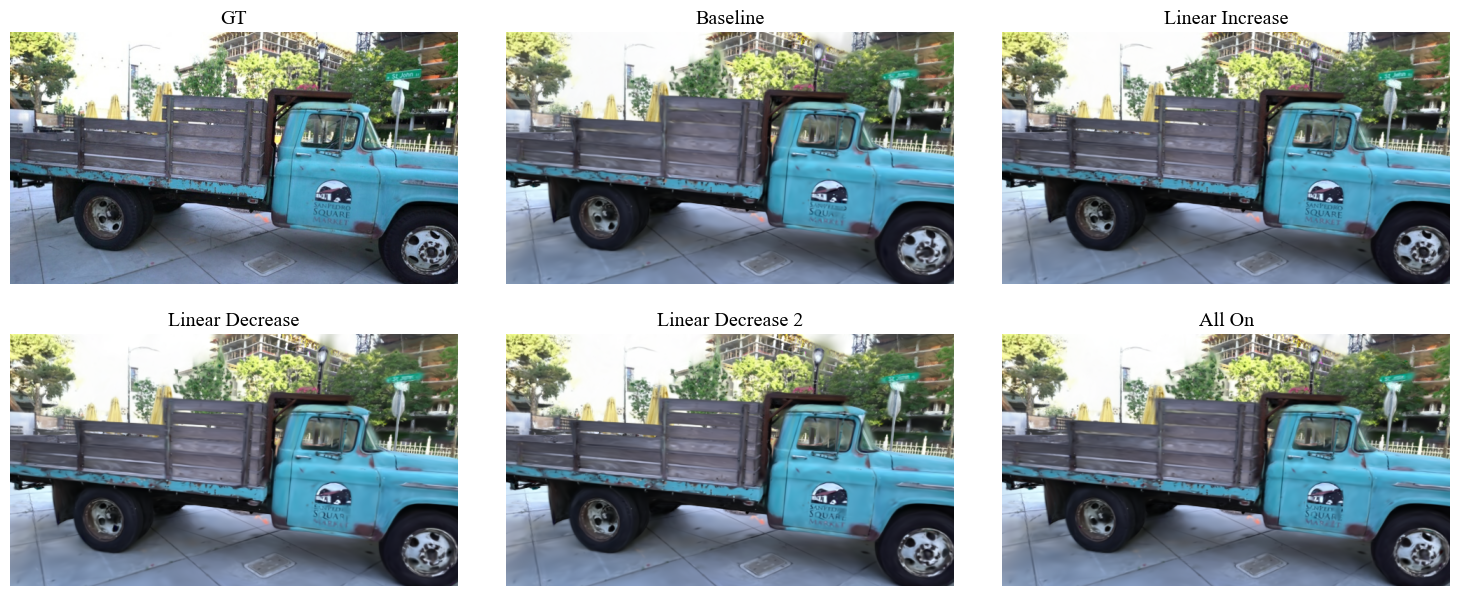

In [8]:
model_folder_list = {
    "Baseline": "./output/coarse/resized/sugarcoarse_3Dgs7000_const_0_supervised_sdfestim02_sdfnorm02",
    #"All Supervised": "./output/coarse/resized/sugarcoarse_3Dgs7000_const_1_supervised_sdfestim02_sdfnorm02",
    "Linear Increase": "./output/coarse/resized/sugarcoarse_3Dgs7000_linear_supervised_sdfestim02_sdfnorm02",
    "Linear Decrease": "./output/coarse/resized/sugarcoarse_3Dgs7000_linear2_supervised_sdfestim02_sdfnorm02",
    "Linear Decrease 2": "./output/coarse/resized/sugarcoarse_3Dgs7000_linear3_supervised_sdfestim02_sdfnorm02",
    "All On": "./output/coarse/resized/sugarcoarse_3Dgs7000_custom_3_supervised_sdfestim02_sdfnorm02"
}

onsamerow = True
also_render_vanilla_3dgs = True
cameras_to_use = nerfmodel.training_cameras
#cam_idx = np.random.randint(0, len(cameras_to_use.gs_cameras))
cam_idx=96
print(f"Rendering image with index {cam_idx}.")
print("Image name:", cameras_to_use.gs_cameras[cam_idx].image_name)

from collections import OrderedDict

images = OrderedDict()
images["GT"] = nerfmodel.get_gt_image(
    camera_indices=cam_idx,
).clamp(min=0, max=1).cpu().numpy()

for name, coarse_sugar_folder in model_folder_list.items():
    refined_iteration_to_load = 15_000
    coarse_sugar_path = os.path.join(coarse_sugar_folder, f"{refined_iteration_to_load}.pt")
    print(f"\nLoading config {coarse_sugar_path}...")
    from sugar_scene.sugar_model import SuGaR
    checkpoint = torch.load(coarse_sugar_path, map_location=nerfmodel.device, weights_only=False)
    coarse_sugar = SuGaR(
        nerfmodel=nerfmodel,
        points=checkpoint['state_dict']['_points'],
        colors=SH2RGB(checkpoint['state_dict']['_sh_coordinates_dc'][:, 0, :]),
        initialize=False,
        sh_levels=4,  # Adjust based on your model
        learnable_positions=True,
        n_gaussians_per_surface_triangle=1,
        beta_mode='average',
        keep_track_of_knn=False,
        knn_to_track=0,
    )
    coarse_sugar.load_state_dict(checkpoint['state_dict'])
    coarse_sugar.eval()
    coarse_sugar.adapt_to_cameras(cameras_to_use)
    with torch.no_grad():
        gs_image = nerfmodel.get_gt_image(
            camera_indices=cam_idx,
            #override_color=torch.tensor([0.2,0.1,0.4],device="cuda").unsqueeze(0).unsqueeze(0).expand(nerfmodel.gaussians.get_features.shape)
        ).clamp(min=0, max=1)
        
        sugar_image = coarse_sugar.render_image_gaussian_rasterizer(
            nerf_cameras=cameras_to_use, 
            camera_indices=cam_idx,
            sh_deg=nerfmodel.gaussians.active_sh_degree,
            compute_color_in_rasterizer=True,
        ).nan_to_num().clamp(min=0, max=1)

        depth_image, normal_image = coarse_sugar.render_depth_and_normal(
            nerf_cameras=cameras_to_use, 
            camera_indices=cam_idx,
        )
        depth_image = depth_image.nan_to_num().clamp(min=0, max=5)
        normal_image = normal_image.nan_to_num()

    #images[name] = (normal_image.cpu().numpy()) * 0.5 + 0.5
    images[name] = (sugar_image.cpu().numpy())

from math import ceil
plt.rcParams['font.family'] = 'serif' 
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 12  
idx = 0
plt_h = 9/2.5
plt_w = 16/2.5
h = 2
w = ceil(len(images) / 2.0)
fig, axes = plt.subplots(h, w, figsize=(plt_w * w, plt_h * h))
fig.subplots_adjust(wspace=0.001)  # Adjust column spacing
axes = axes.flatten()  # Flatten the axes array for easier indexing
for name, image in images.items():
    axes[idx].axis("off")
    axes[idx].set_title(name)
    axes[idx].imshow(image)
    idx += 1
# Hide axes for unused subplots
for i in range(idx, len(axes)):
    axes[i].axis("off")
plt.show()
torch.cuda.empty_cache()